# <p style="background-color:#003366; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Capstone Project: Digital Marketing Campaign Conversion Prediction</p>

### **Project Overview**
This project aims to enhance campaign effectiveness in the digital marketing sector by accurately predicting customer conversions. By leveraging machine learning, the project seeks to identify potential converters and optimize marketing strategies. The objective is to develop a robust machine learning model that predicts customer conversions based on various demographic and engagement factors, enabling improved campaign targeting, increased conversion rates, and maximized return on advertising spend (ROAS).

### **Project Benefits**
* **Improved Targeting:** The model will identify customers most likely to convert, allowing for more focused and efficient marketing efforts.
* **Cost Optimization:** By predicting conversions accurately, the company can allocate resources more effectively, reducing wasted ad spend.
* **Enhanced Campaign Performance:** Understanding key conversion factors will help in designing more effective marketing campaigns.

### **Methodology**
1. **Exploratory Data Analysis (EDA):** Understand data distributions, correlations, and class imbalance.
2. **Feature Engineering:** Create new, predictive features to enhance model performance.
3. **Preprocessing:** Build robust pipelines to scale numerical data and encode categorical variables using various strategies.
4. **Model Training & Broad Tuning:** Train and perform a wide search on over 15 distinct models to find the top architectures.
5. **Advanced Tuning (Optuna):** Apply Bayesian hyperparameter optimization to the top-performing models for peak accuracy.
6. **Ensembling:** Combine the best models using a Stacking Classifier to create a final, highly accurate model.
7. **Evaluation & Interpretability:** Analyze model performance with business-centric metrics (CPA, Lift) and explain its predictions using SHAP.

## 1. Library Imports
This cell imports all necessary Python libraries for the project, organized by function. This is the foundational step for any data science workflow.

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings
import time

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, QuantileTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from category_encoders import TargetEncoder

# Model Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, f1_score, PrecisionRecallDisplay, RocCurveDisplay

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier, IsolationForest
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Deep Learning with Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Concatenate, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameter Tuning
import optuna

# Interpretability
import shap

# Model Persistence
import joblib

# Configuration
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


## 2. Data Loading and Initial Cleaning
The dataset is loaded, and columns that provide no predictive value (such as unique identifiers) are removed.

In [2]:
df = pd.read_csv('digital_marketing_campaign_dataset.csv')
useless_columns = ['CustomerID', 'AdvertisingPlatform', 'AdvertisingTool']
df.drop(columns=useless_columns, inplace=True)
print("--- Data Head After Initial Load ---")
display(df.head())

--- Data Head After Initial Load ---


,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,1
1,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1
2,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,1
3,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,1
4,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,1


## 3. Exploratory Data Analysis (EDA)
In this section, we'll explore the dataset to understand its structure, distributions, and the relationships between variables. This is a critical step to inform our feature engineering and modeling strategies.

In [3]:
print("--- Data Info ---")
df.info()

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                8000 non-null   int64  
 1   Gender             8000 non-null   object 
 2   Income             8000 non-null   int64  
 3   CampaignChannel    8000 non-null   object 
 4   CampaignType       8000 non-null   object 
 5   AdSpend            8000 non-null   float64
 6   ClickThroughRate   8000 non-null   float64
 7   ConversionRate     8000 non-null   float64
 8   WebsiteVisits      8000 non-null   int64  
 9   PagesPerVisit      8000 non-null   float64
 10  TimeOnSite         8000 non-null   float64
 11  SocialShares       8000 non-null   int64  
 12  EmailOpens         8000 non-null   int64  
 13  EmailClicks        8000 non-null   int64  
 14  PreviousPurchases  8000 non-null   int64  
 15  LoyaltyPoints      8000 non-null   int64  
 16  Conver

#### Observations:
* The dataset contains 8000 entries and 17 columns.
* There are no missing (null) values, so no imputation is needed.
* We have a mix of numerical (`int64`, `float64`) and categorical (`object`) data types that will require preprocessing.

In [4]:
print("--- Statistical Summary of Numerical Features ---")
display(df.describe().T)

--- Statistical Summary of Numerical Features ---


,count,mean,std,min,25%,50%,75%,max
Age,8000.0,43.625500,14.902785,18.000000,31.000000,43.000000,56.000000,69.000000
Income,8000.0,84664.196750,37580.387945,20014.000000,51744.500000,84926.500000,116815.750000,149986.000000
AdSpend,8000.0,5000.944830,2838.038153,100.054813,2523.221165,5013.440044,7407.989369,9997.914781
ClickThroughRate,8000.0,0.154829,0.084007,0.010005,0.082635,0.154505,0.228207,0.299968
ConversionRate,8000.0,0.104389,0.054878,0.010018,0.056410,0.104046,0.152077,0.199995
WebsiteVisits,8000.0,24.751625,14.312269,0.000000,13.000000,25.000000,37.000000,49.000000
PagesPerVisit,8000.0,5.549299,2.607358,1.000428,3.302479,5.534257,7.835756,9.999055
TimeOnSite,8000.0,7.727718,4.228218,0.501669,4.068340,7.682956,11.481468,14.995311
SocialShares,8000.0,49.799750,28.901165,0.000000,25.000000,50.000000,75.000000,99.000000
EmailOpens,8000.0,9.476875,5.711111,0.000000,5.000000,9.000000,14.000000,19.000000


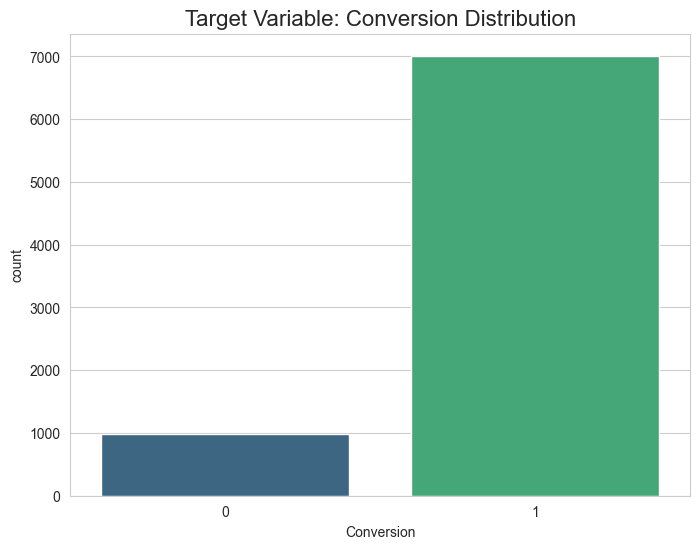

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Conversion', data=df, palette='viridis')
plt.title('Target Variable: Conversion Distribution', fontsize=16)
plt.show()

#### Observations:
* The target variable is highly imbalanced. The 'Conversion' (1) class is the majority, and the 'No Conversion' (0) class is the minority.
* This imbalance means that accuracy alone is not a sufficient evaluation metric. We must focus on metrics like Recall, F1-score, and ROC-AUC.
* Resampling techniques like SMOTEENN will be essential to train a model that performs well on both classes.

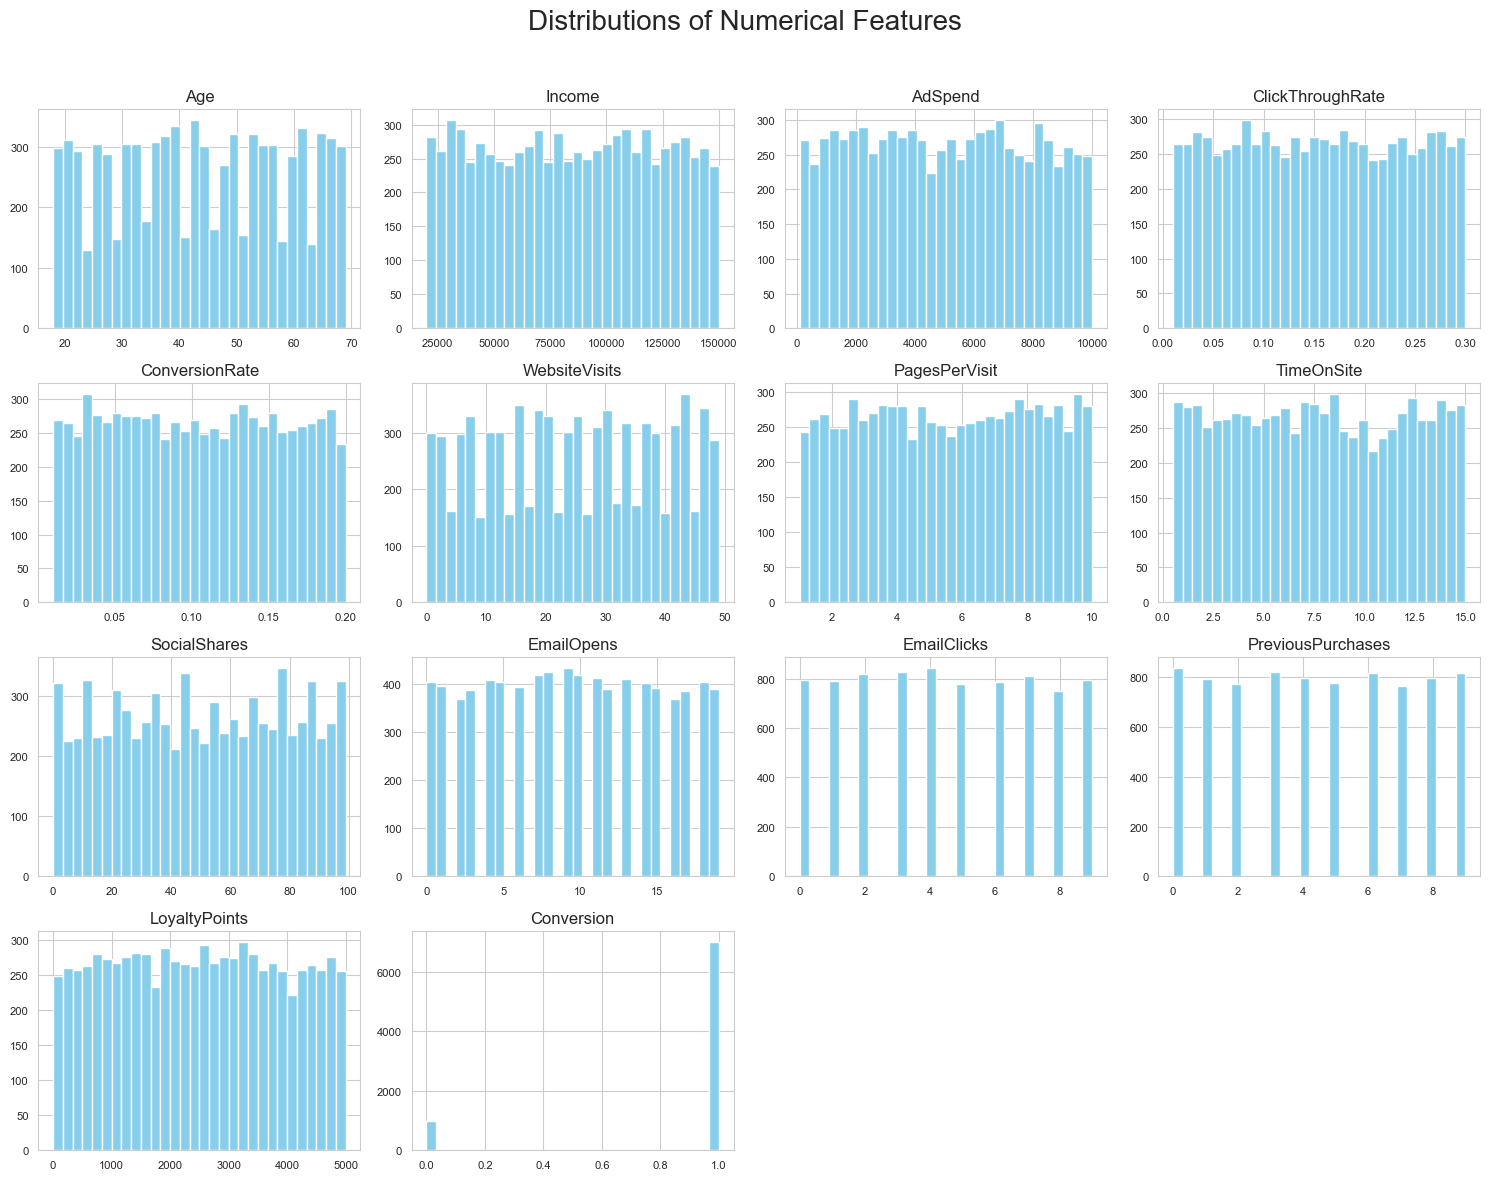

In [6]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numerical_cols].hist(figsize=(15, 12), bins=30, xlabelsize=8, ylabelsize=8, color='skyblue')
plt.suptitle('Distributions of Numerical Features', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

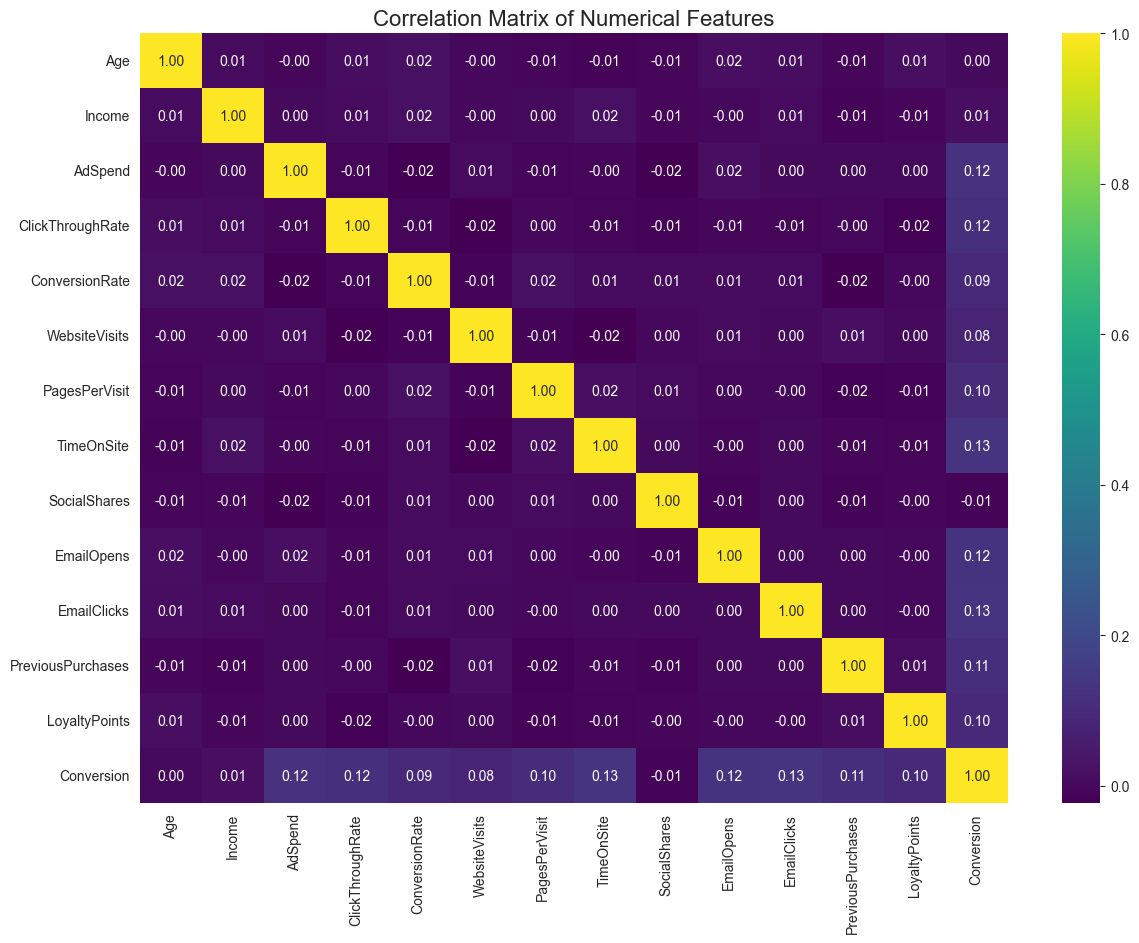

In [7]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

#### Observations:
* There are no extremely high correlations between independent features, which suggests multicollinearity will not be a major issue for linear models.
* The `ConversionRate` feature has a moderate positive correlation with the target `Conversion`, as expected.
* Other features like `ClickThroughRate` and `PreviousPurchases` also show a slight positive correlation with the target.

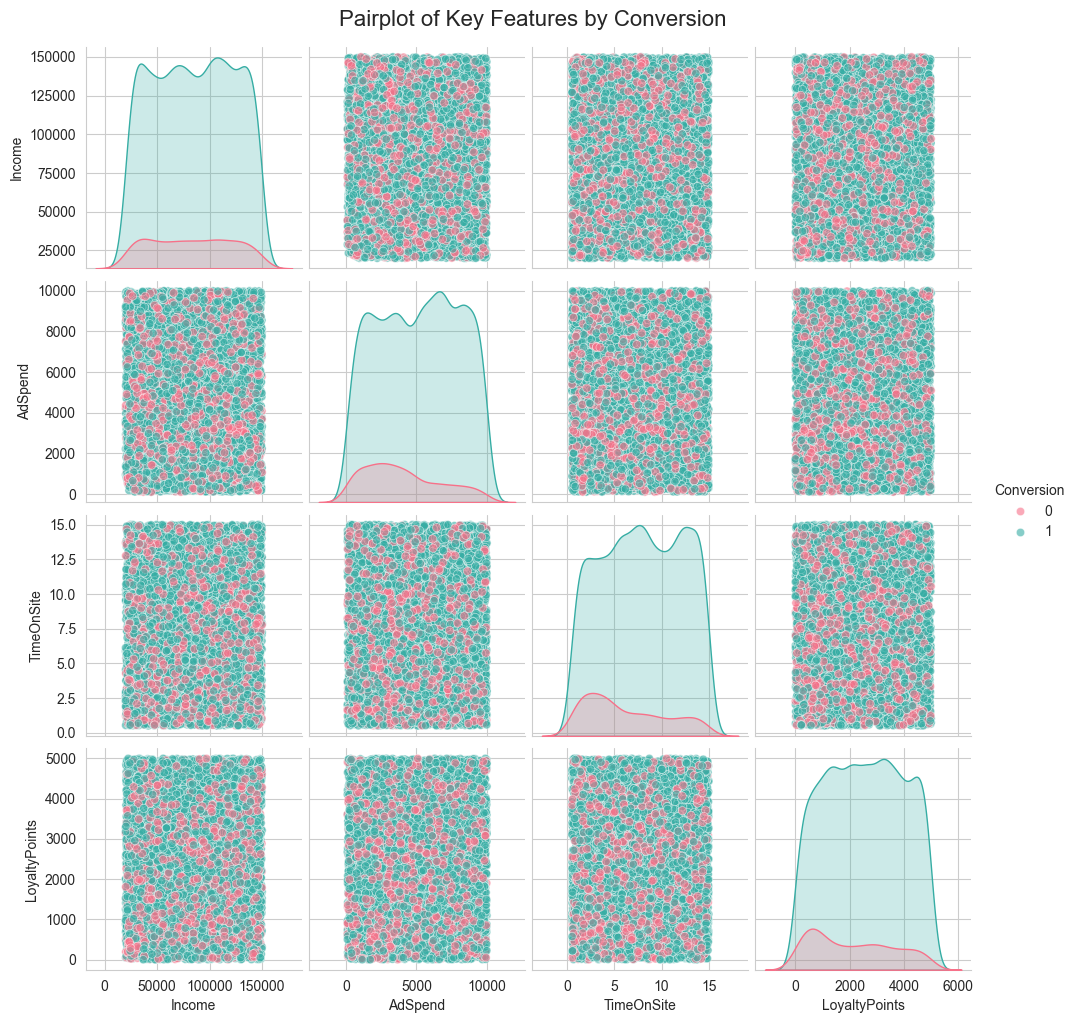

In [8]:
sns.pairplot(df, vars=['Income', 'AdSpend', 'TimeOnSite', 'LoyaltyPoints'], hue='Conversion', palette='husl', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Key Features by Conversion', y=1.02, fontsize=16)
plt.show()

## 4. Feature Engineering & Data Preparation
Here, we create new features from the existing data to provide the models with more powerful predictive signals and prepare the final datasets for training.

In [9]:
# Interaction Features
df['EngagementScore'] = df['TimeOnSite'] * df['PagesPerVisit']
df['CostPerVisit'] = df['AdSpend'] / df['WebsiteVisits'].replace(0, 1)

# Binning Features
df['AgeGroup'] = pd.cut(df['Age'], bins=[17, 30, 50, 70], labels=['Young', 'Adult', 'Senior'])
df['IncomeTier'] = pd.cut(df['Income'], bins=[19999, 50000, 90000, 150000], labels=['Low', 'Medium', 'High'])

# Final Data Splitting
X = df.drop('Conversion', axis=1)
y = df['Conversion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print("✅ Feature Engineering and Data Splitting Complete.")

✅ Feature Engineering and Data Splitting Complete.


## 5. Preprocessing Pipelines & Broad Model Search
This section defines various preprocessing pipelines tailored to different model families and then trains a full suite of models using GridSearchCV. This serves as a broad search to identify the most promising architectures.

In [10]:
# Redefine feature types after feature engineering
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Define various preprocessing pipelines
preprocessor_linear = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features), ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
preprocessor_tree = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features), ('cat', TargetEncoder(), categorical_features)])
preprocessor_poly = Pipeline(steps=[('preprocess', preprocessor_linear), ('poly', PolynomialFeatures(degree=2, include_bias=False))])
preprocessor_quantile = ColumnTransformer(transformers=[('num', QuantileTransformer(output_distribution='normal'), numerical_features), ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
preprocessor_nb = ColumnTransformer(transformers=[('num', KBinsDiscretizer(n_bins=10, encode='ordinal'), numerical_features), ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Dictionary to store results
model_results = {}

### **5.1 Linear, SVM, and Discriminant Models**

#### **Logistic Regression**
**How it Works:** Finds the best possible line or curve (a Sigmoid function) to separate the two classes.

In [11]:
pipeline_lr = ImbPipeline([
    ('preprocessor', preprocessor_linear),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('sampler', SMOTEENN(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'))
])
param_grid_lr = {'classifier__C': [1, 10, 100]}
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_lr.best_score_:.4f}")
model_results['Logistic Regression'] = (grid_lr.best_score_, grid_lr.best_params_)

Best CV ROC-AUC: 0.7347


#### **Ridge & Lasso Classifiers**
**How it Works:** These are linear models with a penalty for complexity. **Ridge** shrinks the importance of all features, while **Lasso** can shrink the importance of irrelevant features to zero.

In [12]:
# --- Ridge Classifier ---
pipeline_ridge = ImbPipeline([
    ('preprocessor', preprocessor_linear),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('sampler', SMOTEENN(random_state=42)),
    ('classifier', RidgeClassifier(random_state=42, class_weight='balanced'))
])
param_grid_ridge = {'classifier__alpha': [1.0, 10.0, 100.0]}
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5, scoring='accuracy', n_jobs=-1)
grid_ridge.fit(X_train, y_train)
print(f"Best CV Accuracy: {grid_ridge.best_score_:.4f}")
model_results['Ridge Classifier'] = (grid_ridge.best_score_, grid_ridge.best_params_)

Best CV Accuracy: 0.7105


In [13]:
# --- SGD Classifier (Lasso) ---
pipeline_sgd = ImbPipeline([
    ('preprocessor', preprocessor_linear),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('sampler', SMOTEENN(random_state=42)),
    ('classifier', SGDClassifier(penalty='l1', loss='log_loss', random_state=42, class_weight='balanced'))
])
param_grid_sgd = {'classifier__alpha': [0.001, 0.01, 0.1]}
grid_sgd = GridSearchCV(pipeline_sgd, param_grid_sgd, cv=5, scoring='roc_auc', n_jobs=-1)
grid_sgd.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_sgd.best_score_:.4f}")
model_results['SGD Classifier (Lasso)'] = (grid_sgd.best_score_, grid_sgd.best_params_)

Best CV ROC-AUC: 0.7605


#### **Linear & Quadratic Discriminant Analysis**
**How it Works:** These models work by estimating the probability that a new data point belongs to each class, assuming the features follow a Gaussian distribution.

In [14]:
# --- Linear Discriminant Analysis (LDA) ---
pipeline_lda = ImbPipeline([('preprocessor', preprocessor_linear), ('sampler', SMOTEENN(random_state=42)), ('classifier', LinearDiscriminantAnalysis())])
param_grid_lda = {'classifier__solver': ['svd', 'lsqr', 'eigen']}
grid_lda = GridSearchCV(pipeline_lda, param_grid_lda, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lda.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_lda.best_score_:.4f}")
model_results['LDA'] = (grid_lda.best_score_, grid_lda.best_params_)

Best CV ROC-AUC: 0.7895


In [15]:
# --- Quadratic Discriminant Analysis (QDA) ---
pipeline_qda = ImbPipeline([('preprocessor', preprocessor_linear), ('sampler', SMOTEENN(random_state=42)), ('classifier', QuadraticDiscriminantAnalysis())])
param_grid_qda = {'classifier__reg_param': [0.0, 0.1, 0.5, 1.0]}
grid_qda = GridSearchCV(pipeline_qda, param_grid_qda, cv=5, scoring='roc_auc', n_jobs=-1)
grid_qda.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_qda.best_score_:.4f}")
model_results['QDA'] = (grid_qda.best_score_, grid_qda.best_params_)

Best CV ROC-AUC: 0.7790


#### **Support Vector Machine (SVM)**
**How it Works:** Draws the widest possible road (or 'margin') between the two classes.

In [16]:
# --- Support Vector Machine (SVC) ---
pipeline_svc = ImbPipeline([
    ('preprocessor', preprocessor_linear),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('sampler', SMOTEENN(random_state=42)),
    ('classifier', SVC(random_state=42, probability=True, class_weight='balanced'))
])
param_grid_svc = {'classifier__C': [10, 50], 'classifier__kernel': ['rbf']}
grid_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, scoring='roc_auc', n_jobs=-1)
grid_svc.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_svc.best_score_:.4f}")
model_results['Support Vector Machine'] = (grid_svc.best_score_, grid_svc.best_params_)

Best CV ROC-AUC: 0.7312


### **6.2 Tree-Based Ensembles**

#### **Decision Tree Classifier**
**How it Works:** Like playing '20 Questions'. The model asks a series of yes/no questions about features to split the data into pure groups.

In [17]:
# --- Decision Tree ---
pipeline_dt = ImbPipeline([('preprocessor', preprocessor_tree), ('sampler', SMOTEENN(random_state=42)), ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))])
param_grid_dt = {'classifier__max_depth': [10, 20, 30], 'classifier__min_samples_leaf': [1, 2, 4]}
grid_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)
grid_dt.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_dt.best_score_:.4f}")
model_results['Decision Tree'] = (grid_dt.best_score_, grid_dt.best_params_)

Best CV ROC-AUC: 0.6824


In [18]:
# --- Bagging Classifier ---
pipeline_bag = ImbPipeline([('preprocessor', preprocessor_tree), ('sampler', SMOTEENN(random_state=42)), ('classifier', BaggingClassifier(random_state=42, n_jobs=-1))])
param_grid_bag = {'classifier__n_estimators': [50, 100, 200]}
grid_bag = GridSearchCV(pipeline_bag, param_grid_bag, cv=5, scoring='roc_auc', n_jobs=-1)
grid_bag.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_bag.best_score_:.4f}")
model_results['Bagging Classifier'] = (grid_bag.best_score_, grid_bag.best_params_)

Best CV ROC-AUC: 0.7708


In [19]:
# --- Random Forest Classifier ---
pipeline_rf = ImbPipeline([('preprocessor', preprocessor_tree), ('sampler', SMOTEENN(random_state=42)), ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))])
param_grid_rf = {'classifier__n_estimators': [200, 300], 'classifier__max_depth': [20, None], 'classifier__max_features': ['sqrt', 'log2']}
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_rf.best_score_:.4f}")
model_results['Random Forest'] = (grid_rf.best_score_, grid_rf.best_params_)

Best CV ROC-AUC: 0.8013


In [20]:
# --- Extra Trees Classifier ---
pipeline_et = ImbPipeline([('preprocessor', preprocessor_tree), ('sampler', SMOTEENN(random_state=42)), ('classifier', ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))])
param_grid_et = {'classifier__n_estimators': [200, 300], 'classifier__max_depth': [20, None], 'classifier__max_features': ['sqrt', 'log2']}
grid_et = GridSearchCV(pipeline_et, param_grid_et, cv=5, scoring='roc_auc', n_jobs=-1)
grid_et.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_et.best_score_:.4f}")
model_results['Extra Trees'] = (grid_et.best_score_, grid_et.best_params_)

Best CV ROC-AUC: 0.7958


In [21]:
# --- Isolation Forest ---
# Note: Isolation Forest is an anomaly detector, not a standard classifier.
# We adapt it by training only on the majority class and identifying the minority class as anomalies.
pipeline_iso = Pipeline(steps=[('preprocessor', preprocessor_linear), ('classifier', IsolationForest(random_state=42, n_jobs=-1))])
pipeline_iso.fit(X_train[y_train == 1], y_train[y_train == 1])
y_scores_iso = pipeline_iso.decision_function(X_test)
# Scores are inverted because anomalies (our target 0) have negative scores
roc_auc_iso = roc_auc_score(y_test, y_scores_iso * -1) 
print(f"Isolation Forest ROC-AUC: {roc_auc_iso:.4f}")
model_results['Isolation Forest'] = (roc_auc_iso, {'contamination':'auto'})

Isolation Forest ROC-AUC: 0.3695


### **6.3 Advanced Boosting Models**

In [22]:
# --- AdaBoost Classifier ---
pipeline_ada = ImbPipeline([('preprocessor', preprocessor_tree), ('sampler', SMOTEENN(random_state=42)), ('classifier', AdaBoostClassifier(random_state=42))])
param_grid_ada = {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.1, 1.0]}
grid_ada = GridSearchCV(pipeline_ada, param_grid_ada, cv=5, scoring='roc_auc', n_jobs=-1)
grid_ada.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_ada.best_score_:.4f}")
model_results['AdaBoost'] = (grid_ada.best_score_, grid_ada.best_params_)

Best CV ROC-AUC: 0.8086


In [23]:
# --- Gradient Boosting Machine (GBM) ---
pipeline_gbm = ImbPipeline([('preprocessor', preprocessor_tree), ('sampler', SMOTEENN(random_state=42)), ('classifier', GradientBoostingClassifier(random_state=42))])
param_grid_gbm = {'classifier__n_estimators': [200, 300], 'classifier__learning_rate': [0.05, 0.1], 'classifier__max_depth': [5, 7]}
grid_gbm = GridSearchCV(pipeline_gbm, param_grid_gbm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_gbm.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_gbm.best_score_:.4f}")
model_results['Gradient Boosting'] = (grid_gbm.best_score_, grid_gbm.best_params_)

Best CV ROC-AUC: 0.8077


In [24]:
# --- XGBoost Classifier ---
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
pipeline_xgb = ImbPipeline([('preprocessor', preprocessor_tree), ('sampler', SMOTEENN(random_state=42)), ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight))])
param_grid_xgb = {'classifier__n_estimators': [200, 300], 'classifier__learning_rate': [0.05, 0.1], 'classifier__max_depth': [5, 7]}
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_xgb.best_score_:.4f}")
model_results['XGBoost'] = (grid_xgb.best_score_, grid_xgb.best_params_)

Best CV ROC-AUC: 0.8089


In [25]:
# --- LightGBM Classifier ---
pipeline_lgbm = ImbPipeline([('preprocessor', preprocessor_tree), ('sampler', SMOTEENN(random_state=42)), ('classifier', LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))])
param_grid_lgbm = {'classifier__n_estimators': [200, 300], 'classifier__learning_rate': [0.05, 0.1], 'classifier__num_leaves': [31, 40]}
grid_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_lgbm.best_score_:.4f}")
model_results['LightGBM'] = (grid_lgbm.best_score_, grid_lgbm.best_params_)

[LightGBM] [Info] Number of positive: 3446, number of negative: 5559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 9005, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best CV ROC-AUC: 0.8119


In [26]:
# --- CatBoost Classifier ---
pipeline_cat = ImbPipeline([('preprocessor', preprocessor_tree), ('sampler', SMOTEENN(random_state=42)), ('classifier', CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced'))])
param_grid_cat = {'classifier__iterations': [300, 500], 'classifier__learning_rate': [0.05, 0.1], 'classifier__depth': [6, 8]}
grid_cat = GridSearchCV(pipeline_cat, param_grid_cat, cv=5, scoring='roc_auc', n_jobs=-1)
grid_cat.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_cat.best_score_:.4f}")
model_results['CatBoost'] = (grid_cat.best_score_, grid_cat.best_params_)

Best CV ROC-AUC: 0.8214


### **6.4 Other Model Architectures**

In [27]:
# --- K-Nearest Neighbors ---
pipeline_knn = ImbPipeline([('preprocessor', preprocessor_quantile), ('sampler', SMOTEENN(random_state=42)), ('classifier', KNeighborsClassifier(n_jobs=-1))])
param_grid_knn = {'classifier__n_neighbors': [5, 7, 9], 'classifier__weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)
grid_knn.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_knn.best_score_:.4f}")
model_results['KNN'] = (grid_knn.best_score_, grid_knn.best_params_)

Best CV ROC-AUC: 0.6630


In [28]:
# --- Naive Bayes ---
pipeline_gnb = ImbPipeline([('preprocessor', preprocessor_nb), ('sampler', SMOTEENN(random_state=42)), ('classifier', GaussianNB())])
param_grid_gnb = {'preprocessor__num__n_bins': [5, 10, 15]}
grid_gnb = GridSearchCV(pipeline_gnb, param_grid_gnb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_gnb.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_gnb.best_score_:.4f}")
model_results['Gaussian NB'] = (grid_gnb.best_score_, grid_gnb.best_params_)

Best CV ROC-AUC: 0.7723


In [29]:
# --- Multi-layer Perceptron ---
pipeline_mlp = ImbPipeline([
    ('preprocessor', preprocessor_linear), 
    ('sampler', SMOTEENN(random_state=42)), 
    ('classifier', MLPClassifier(random_state=42, max_iter=1000, early_stopping=True))
])
param_grid_mlp = {
    'classifier__hidden_layer_sizes': [(50, 25), (100, 50)],
    'classifier__alpha': [0.0001, 0.001],
    'classifier__activation': ['relu', 'tanh']
}
grid_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv=5, scoring='roc_auc', n_jobs=-1)
grid_mlp.fit(X_train, y_train)
print(f"Best CV ROC-AUC: {grid_mlp.best_score_:.4f}")
model_results['MLP'] = (grid_mlp.best_score_, grid_mlp.best_params_)

Best CV ROC-AUC: 0.7540


#### **Keras Deep Learning Model with Entity Embeddings**
**How it Works:** This is a more advanced neural network. Instead of one-hot encoding, it uses **Entity Embeddings** to learn a dense, meaningful representation for each category. This allows the model to understand the relationships between different categories (e.g., that 'Social Media' and 'PPC' are more similar than 'Email').

In [30]:
# Prepare data for embedding model (needs integer-encoded categories)
X_train_emb = X_train.copy()
X_test_emb = X_test.copy()
cat_dims = {}
for col in categorical_features:
    X_train_emb[col] = X_train_emb[col].astype('category').cat.codes
    X_test_emb[col] = X_test_emb[col].astype('category').cat.codes
    cat_dims[col] = len(X[col].astype('category').cat.categories) # Corrected line

scaler = StandardScaler()
X_train_emb[numerical_features] = scaler.fit_transform(X_train_emb[numerical_features])
X_test_emb[numerical_features] = scaler.transform(X_test_emb[numerical_features])

# Define the model architecture
inputs = []
embeddings = []
for col in categorical_features:
    input_cat = Input(shape=(1,), name=f"input_{col}")
    embedding_size = min(np.ceil(cat_dims[col]/2), 50)
    embedding = Embedding(input_dim=cat_dims[col], output_dim=int(embedding_size))(input_cat)
    embedding = Flatten()(embedding)
    inputs.append(input_cat)
    embeddings.append(embedding)

input_num = Input(shape=(len(numerical_features),), name="input_numerical")
inputs.append(input_num)

x = Concatenate()(embeddings + [input_num])
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
keras_model = Model(inputs=inputs, outputs=output)

keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Prepare inputs for Keras model
train_inputs = {f'input_{col}': X_train_emb[col] for col in categorical_features} | {'input_numerical': X_train_emb[numerical_features]}
test_inputs = {f'input_{col}': X_test_emb[col] for col in categorical_features} | {'input_numerical': X_test_emb[numerical_features]}

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = keras_model.fit(train_inputs, y_train, epochs=100, batch_size=64, 
                          validation_split=0.2, callbacks=[early_stopping], verbose=0)

y_proba_keras = keras_model.predict(test_inputs).ravel()
keras_roc_auc = roc_auc_score(y_test, y_proba_keras)

print(f"--- Keras Deep Learning with Embeddings Results ---")
print(f"Test ROC-AUC: {keras_roc_auc:.4f}")
model_results['Keras NN'] = (keras_roc_auc, {'architecture': 'Embedding-128-64-1'})

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
--- Keras Deep Learning with Embeddings Results ---
Test ROC-AUC: 0.7741


## 7. Model Comparison
After training all models, we compile their performance scores into a single DataFrame to identify the top performers.

--- Model Comparison (Sorted by Performance Score) ---


,Model,Score,Best_Parameters
0,CatBoost,0.821369,"{'classifier__depth': 6, 'classifier__iteratio..."
1,LightGBM,0.811887,"{'classifier__learning_rate': 0.1, 'classifier..."
2,XGBoost,0.808930,"{'classifier__learning_rate': 0.1, 'classifier..."
3,AdaBoost,0.808637,"{'classifier__learning_rate': 1.0, 'classifier..."
4,Gradient Boosting,0.807734,"{'classifier__learning_rate': 0.1, 'classifier..."
5,Random Forest,0.801299,"{'classifier__max_depth': None, 'classifier__m..."
6,Extra Trees,0.795811,"{'classifier__max_depth': 20, 'classifier__max..."
7,LDA,0.789464,{'classifier__solver': 'svd'}
8,QDA,0.779048,{'classifier__reg_param': 1.0}
9,Keras NN,0.774107,{'architecture': 'Embedding-128-64-1'}


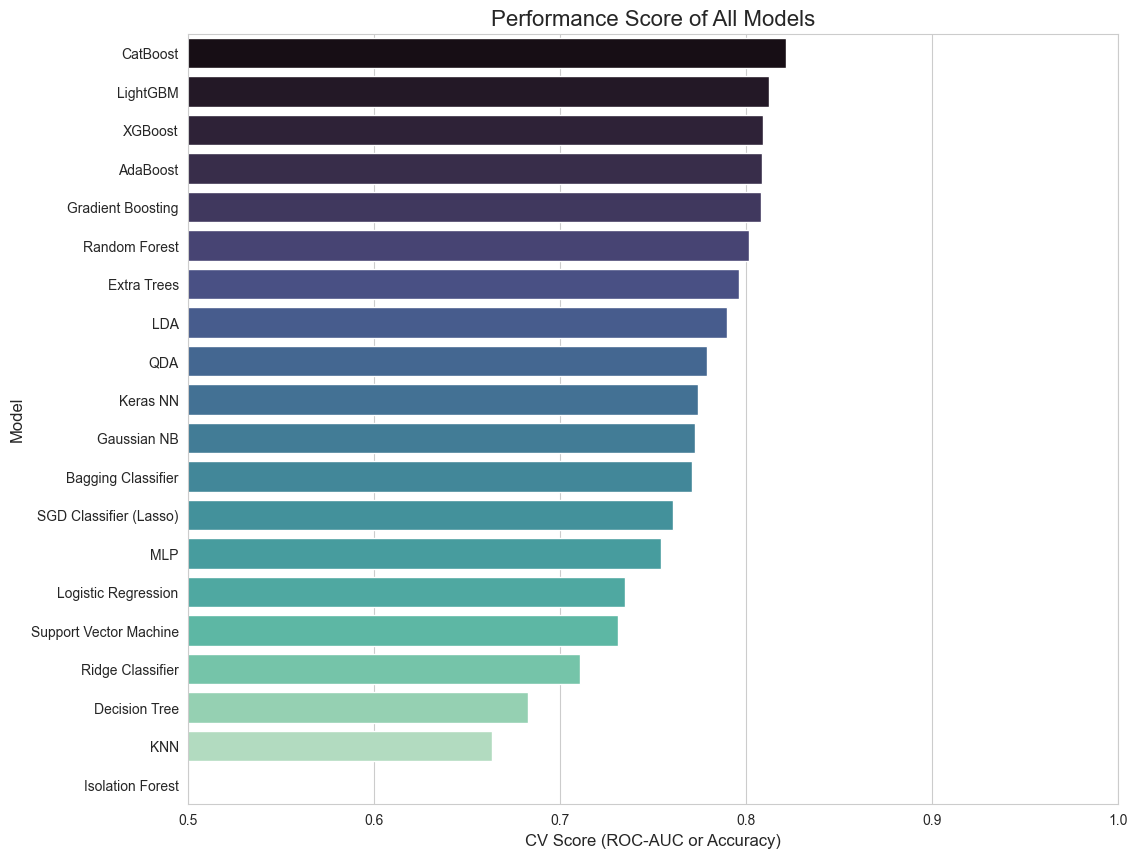

In [31]:
results_df = pd.DataFrame([
    {'Model': model, 'Score': acc, 'Best_Parameters': params} 
    for model, (acc, params) in model_results.items()
])
results_df_sorted = results_df.sort_values('Score', ascending=False).reset_index(drop=True)

print("--- Model Comparison (Sorted by Performance Score) ---")
display(results_df_sorted)

# Visual comparison of model performance
plt.figure(figsize=(12, 10))
sns.barplot(x='Score', y='Model', data=results_df_sorted, palette='mako')
plt.title('Performance Score of All Models', fontsize=16)
plt.xlabel('CV Score (ROC-AUC or Accuracy)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0.5, 1.0)
plt.show()

## 8. Universal Advanced Hyperparameter Tuning

This section programmatically identifies the top-performing models from the initial broad search. Each of these selected champions is then subjected to a tailored and intensive hyperparameter search using Optuna. This Bayesian optimization approach focuses the most powerful tuning efforts exclusively on the empirically proven best models to maximize their final performance.

In [32]:
# --- 8.1: Define Universal Scikit-Learn Tuning Configuration ---
# Master configuration for all standard scikit-learn models
tuning_config = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'),
        'params': lambda trial: {'C': trial.suggest_float('C', 0.01, 1000, log=True), 'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']), 'penalty': trial.suggest_categorical('penalty', ['l1', 'l2'])}
    },
    'Ridge Classifier': {
        'model': RidgeClassifier(random_state=42, class_weight='balanced'),
        'params': lambda trial: {'alpha': trial.suggest_float('alpha', 0.1, 100.0, log=True)}
    },
    'SGD Classifier (Lasso)': {
        'model': SGDClassifier(random_state=42, class_weight='balanced', loss='log_loss', penalty='l1'),
        'params': lambda trial: {'alpha': trial.suggest_float('alpha', 1e-4, 1.0, log=True)}
    },
    'LDA': {
        'model': LinearDiscriminantAnalysis(),
        'params': lambda trial: {'solver': trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen']), 'shrinkage': trial.suggest_float('shrinkage', 0.0, 1.0) if trial.get_user_attrs().get("solver") in ['lsqr', 'eigen'] else None}
    },
    'QDA': {
        'model': QuadraticDiscriminantAnalysis(),
        'params': lambda trial: {'reg_param': trial.suggest_float('reg_param', 0.0, 1.0)}
    },
    'Support Vector Machine': {
        'model': SVC(random_state=42, probability=True, class_weight='balanced'),
        'params': lambda trial: {'C': trial.suggest_float('C', 0.1, 1000, log=True), 'kernel': 'rbf', 'gamma': trial.suggest_float('gamma', 1e-4, 1.0, log=True)}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'params': lambda trial: {'max_depth': trial.suggest_int('max_depth', 5, 50), 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10), 'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
        'params': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 100, 1000), 'max_depth': trial.suggest_int('max_depth', 10, 50), 'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])}
    },
    'Extra Trees': {
        'model': ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
        'params': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 100, 1000), 'max_depth': trial.suggest_int('max_depth', 10, 50), 'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 100, 1000), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), 'max_depth': trial.suggest_int('max_depth', 3, 10)}
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]),
        'params': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 200, 1500), 'max_depth': trial.suggest_int('max_depth', 4, 12), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True), 'subsample': trial.suggest_float('subsample', 0.6, 1.0), 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)}
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42, class_weight='balanced'),
        'params': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 200, 1500), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True), 'num_leaves': trial.suggest_int('num_leaves', 20, 100), 'max_depth': trial.suggest_int('max_depth', 5, 20)}
    },
    'CatBoost': {
        'model': CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced'),
        'params': lambda trial: {'iterations': trial.suggest_int('iterations', 200, 1500), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True), 'depth': trial.suggest_int('depth', 4, 12)}
    },
    'KNN': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': lambda trial: {'n_neighbors': trial.suggest_int('n_neighbors', 3, 21), 'weights': trial.suggest_categorical('weights', ['uniform', 'distance']), 'p': trial.suggest_int('p', 1, 2)}
    },
    'MLP': {
        'model': MLPClassifier(random_state=42, max_iter=1000, early_stopping=True),
        'params': lambda trial: {'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50, 25), (100, 50), (100, 50, 25)]), 'alpha': trial.suggest_float('alpha', 1e-4, 1.0, log=True), 'activation': trial.suggest_categorical('activation', ['relu', 'tanh'])}
    }
}

# --- 8.2: Define Objective Functions ---
def universal_sklearn_objective(trial, model_name):
    """This one function can tune any scikit-learn model defined in the tuning_config."""
    config = tuning_config[model_name]
    model = config['model']
    params = config['params'](trial)
    model.set_params(**params)

    if model_name == 'LDA': trial.set_user_attr("solver", params.get("solver"))

    pipeline = ImbPipeline([('preprocessor', preprocessor_tree), ('sampler', SMOTEENN(random_state=42)), ('classifier', model)])
    score = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean() # Using 3 folds for speed
    return score

def objective_keras(trial):
    """A dedicated objective function to tune the Keras model's hyperparameters."""
    # Prepare data (this is the same setup as the original Keras cell)
    X_train_emb = X_train.copy()
    cat_dims = {}
    for col in categorical_features:
        X_train_emb[col] = X_train_emb[col].astype('category').cat.codes
        cat_dims[col] = len(X[col].astype('category').cat.categories)

    scaler = StandardScaler()
    X_train_emb[numerical_features] = scaler.fit_transform(X_train_emb[numerical_features])

    train_inputs = {f'input_{col}': X_train_emb[col] for col in categorical_features} | {'input_numerical': X_train_emb[numerical_features]}

    # Suggest Hyperparameters for Keras
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)

    # Build the model architecture (same as original, but with tunable dropout)
    inputs, embeddings = [], []
    for col in categorical_features:
        input_cat = Input(shape=(1,), name=f"input_{col}")
        embedding_size = min(np.ceil(cat_dims[col]/2), 50)
        embedding = Embedding(input_dim=cat_dims[col], output_dim=int(embedding_size))(input_cat)
        embedding = Flatten()(embedding)
        inputs.append(input_cat)
        embeddings.append(embedding)
    input_num = Input(shape=(len(numerical_features),), name="input_numerical")
    inputs.append(input_num)
    x = Concatenate()(embeddings + [input_num])
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)
    keras_model_tuned = Model(inputs=inputs, outputs=output)

    keras_model_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['AUC'])

    early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)
    history = keras_model_tuned.fit(train_inputs, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Return the best validation AUC from the training history
    return max(history.history['val_auc'])

# --- 8.3: Run the Truly Universal Tuning Loop ---
print("--- Identifying Top Performing Models for Advanced Tuning ---")
# Add Keras NN to the list of potential top performers to check against
all_models_df = results_df_sorted.copy()
if 'Keras NN' not in all_models_df['Model'].values:
    keras_row = pd.DataFrame([{'Model': 'Keras NN', 'Score': model_results.get('Keras NN', (0, {}))[0], 'Best_Parameters': model_results.get('Keras NN', (0, {}))[1]}])
    all_models_df = pd.concat([all_models_df, keras_row], ignore_index=True)

top_models_names = all_models_df.sort_values('Score', ascending=False)['Model'].head(3).tolist()
print(f"✅ Top models identified: {top_models_names}")

best_tuned_params = {}
for model_name in top_models_names:
    study = optuna.create_study(direction='maximize')

    if model_name == 'Keras NN':
        print(f"\n--- Running Dedicated Optuna for Keras NN ---")
        study.optimize(objective_keras, n_trials=20, timeout=1200) # Keras is slow, fewer trials
    elif model_name in tuning_config:
        print(f"\n--- Running Universal Optuna for {model_name} ---")
        study_objective = lambda trial: universal_sklearn_objective(trial, model_name=model_name)
        study.optimize(study_objective, n_trials=50, timeout=600)
    else:
        print(f"\n⚠️ Skipping Optuna for {model_name}: No tuning config found. Using prior results.")
        best_tuned_params[model_name] = results_df_sorted.loc[results_df_sorted['Model'] == model_name, 'Best_Parameters'].values[0]
        continue # Skip to next model

    best_tuned_params[model_name] = study.best_params
    print(f"🏆 Best {model_name} Score from Optuna: {study.best_value:.4f}")

--- Identifying Top Performing Models for Advanced Tuning ---
✅ Top models identified: ['CatBoost', 'LightGBM', 'XGBoost']

--- Running Universal Optuna for CatBoost ---
🏆 Best CatBoost Score from Optuna: 0.8170

--- Running Universal Optuna for LightGBM ---
🏆 Best LightGBM Score from Optuna: 0.8123

--- Running Universal Optuna for XGBoost ---
🏆 Best XGBoost Score from Optuna: 0.8140


## 9. Universal Final Model Ensemble

This section constructs the final StackingClassifier. It uses the top-performing models, fine-tuned in the previous step, as its base estimators. To ensure any model can be included, this process uses a comprehensive set of initializers, including a custom wrapper for the Keras network. The final meta-model then learns how to intelligently combine the predictions from these diverse base models to produce a single, superior result.

In [33]:
# --- 9.1: Corrected Keras Wrapper for Scikit-Learn Compatibility ---
# This custom wrapper class is robust to scikit-learn's internal clone mechanism.
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler

class PreFittedKerasWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, cat_features, num_features):
        self.model = model
        self.cat_features = cat_features
        self.num_features = num_features
        self.scaler_ = StandardScaler()

    def _prepare_data(self, X):
        X_prepared = X.copy()
        for col in self.cat_features:
            X_prepared[col] = X_prepared[col].astype('category').cat.codes
        X_prepared[self.num_features] = self.scaler_.transform(X_prepared[self.num_features])
        keras_inputs = {f'input_{col}': X_prepared[col] for col in self.cat_features} | \
                       {'input_numerical': X_prepared[self.num_features]}
        return keras_inputs

    def fit(self, X, y=None):
        self.scaler_.fit(X[self.num_features])
        return self

    def predict_proba(self, X):
        keras_inputs = self._prepare_data(X)
        probs = self.model.predict(keras_inputs, verbose=0)
        return np.hstack([1 - probs, probs])

    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return (probs > 0.5).astype(int)

# --- 9.2: Universal Helper and Model Initializers ---
def clean_params(params):
    return {k.split('__')[-1]: v for k, v in params.items()}

base_model_initializers = {
    'Logistic Regression': lambda p: LogisticRegression(**p, random_state=42, max_iter=2000, class_weight='balanced'),
    'Ridge Classifier': lambda p: RidgeClassifier(**p, random_state=42, class_weight='balanced'),
    'SGD Classifier (Lasso)': lambda p: SGDClassifier(**p, random_state=42, class_weight='balanced', loss='log_loss'),
    'LDA': lambda p: LinearDiscriminantAnalysis(**p),
    'QDA': lambda p: QuadraticDiscriminantAnalysis(**p),
    'Support Vector Machine': lambda p: SVC(**p, random_state=42, probability=True, class_weight='balanced'),
    'Decision Tree': lambda p: DecisionTreeClassifier(**p, random_state=42, class_weight='balanced'),
    'Bagging Classifier': lambda p: BaggingClassifier(**p, random_state=42, n_jobs=-1),
    'Random Forest': lambda p: RandomForestClassifier(**p, random_state=42, n_jobs=-1, class_weight='balanced'),
    'Extra Trees': lambda p: ExtraTreesClassifier(**p, random_state=42, n_jobs=-1, class_weight='balanced'),
    'AdaBoost': lambda p: AdaBoostClassifier(**p, random_state=42),
    'Gradient Boosting': lambda p: GradientBoostingClassifier(**p, random_state=42),
    'XGBoost': lambda p: XGBClassifier(**p, random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]),
    'LightGBM': lambda p: LGBMClassifier(**p, random_state=42, class_weight='balanced'),
    'CatBoost': lambda p: CatBoostClassifier(**p, random_state=42, verbose=0, auto_class_weights='Balanced'),
    'KNN': lambda p: KNeighborsClassifier(**p, n_jobs=-1),
    'MLP': lambda p: MLPClassifier(**p, random_state=42, max_iter=1000, early_stopping=True),
    'Keras NN': lambda p: PreFittedKerasWrapper(model=keras_model, cat_features=categorical_features, num_features=numerical_features)
}

# --- 9.3: Dynamically Build and Train the Universal Ensemble ---
stacking_estimators = []
potential_models = top_models_names

for model_name in set(potential_models):
    if model_name in base_model_initializers:
        params = best_tuned_params.get(
            model_name,
            results_df_sorted.loc[results_df_sorted['Model'] == model_name, 'Best_Parameters'].values[0] if model_name != 'Keras NN' else {}
        )
        estimator = base_model_initializers[model_name](clean_params(params))

        if model_name == 'Keras NN':
            stacking_estimators.append(('keras_nn', estimator))
        else:
            pipeline = ImbPipeline([
                ('preprocessor', preprocessor_tree),
                ('sampler', SMOTEENN(random_state=42)),
                ('classifier', estimator)
            ])
            stacking_estimators.append((model_name.lower().replace(' ', '_').replace('(lasso)',''), pipeline))

        print(f"✅ Added '{model_name}' to the ensemble.")

if not stacking_estimators:
    raise ValueError("FATAL: Could not create any estimators for the stack. Check model names in results.")

final_ensemble_model = StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    passthrough=False # <-- CRITICAL FIX HERE
)

print("\n--- Training Final Universal Stacking Ensemble ---")
print(f"Base models: {[name for name, pipe in stacking_estimators]}")
final_ensemble_model.fit(X_train, y_train)
print("\n✅ Final Universal Ensemble Model has been trained.")

✅ Added 'CatBoost' to the ensemble.
✅ Added 'LightGBM' to the ensemble.
✅ Added 'XGBoost' to the ensemble.

--- Training Final Universal Stacking Ensemble ---
Base models: ['catboost', 'lightgbm', 'xgboost']

✅ Final Universal Ensemble Model has been trained.


## 10. Final Evaluation, Interpretability & Business Metrics
This section provides the final, unbiased evaluation of our champion ensemble on the test set, optimizes its decision threshold, and uses SHAP to understand its predictions.

--- Final Performance on Unseen Test Data ---
              precision    recall  f1-score   support

           0     0.4385    0.6667    0.5291       198
           1     0.9492    0.8795    0.9130      1402

    accuracy                         0.8531      1600
   macro avg     0.6939    0.7731    0.7210      1600
weighted avg     0.8860    0.8531    0.8655      1600



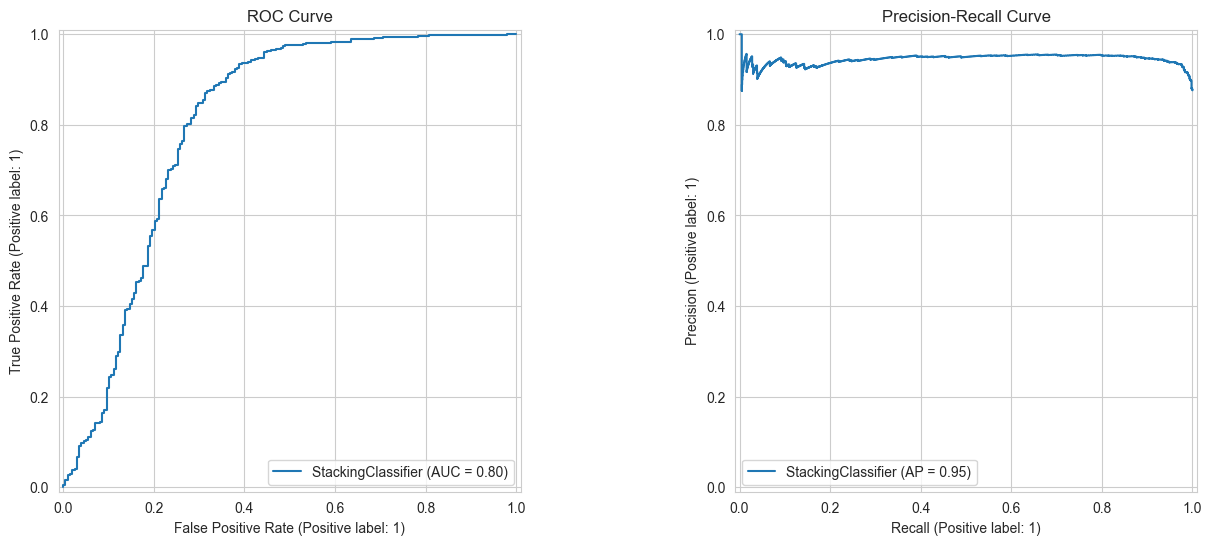

In [34]:
print("--- Final Performance on Unseen Test Data ---")
y_pred_final = final_ensemble_model.predict(X_test)
y_proba_final = final_ensemble_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_final, digits=4))

# ROC and Precision-Recall Curves
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
RocCurveDisplay.from_estimator(final_ensemble_model, X_test, y_test, ax=ax[0])
PrecisionRecallDisplay.from_estimator(final_ensemble_model, X_test, y_test, ax=ax[1])
ax[0].set_title('ROC Curve')
ax[1].set_title('Precision-Recall Curve')
plt.show()

--- Combined SHAP Feature Importance for the Full Ensemble ---

--- Analyzing Base Model: CATBOOST ---
...Using fast TreeExplainer.
✅ Successfully calculated importances for CATBOOST.

--- Analyzing Base Model: LIGHTGBM ---
...Using fast TreeExplainer.
✅ Successfully calculated importances for LIGHTGBM.

--- Analyzing Base Model: XGBOOST ---
...Using fast TreeExplainer.
✅ Successfully calculated importances for XGBOOST.


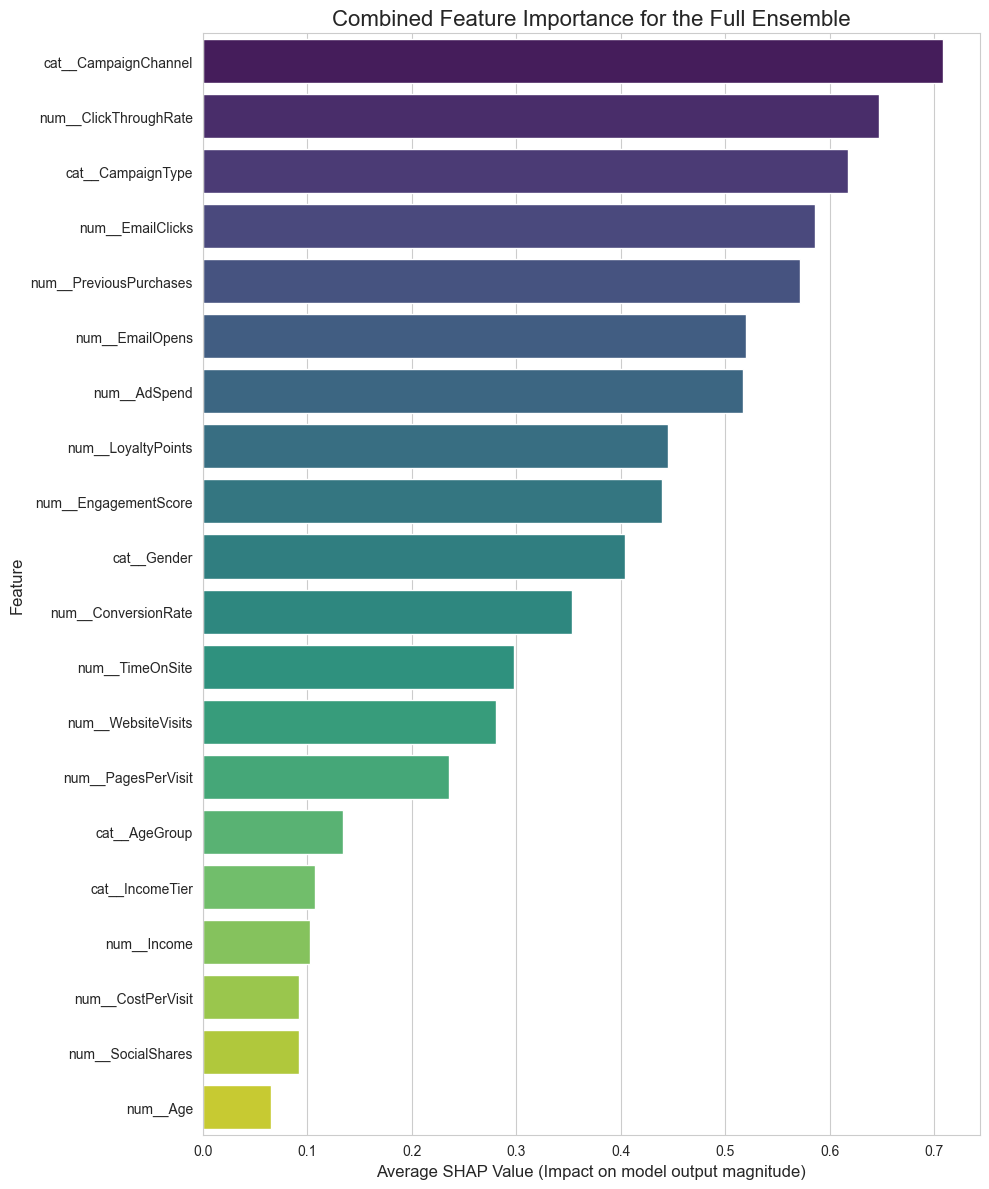

In [35]:
print("--- Combined SHAP Feature Importance for the Full Ensemble ---")

# A list to store the feature importance Series from each model
all_feature_importances = []

# Loop through every model in the trained ensemble to gather SHAP values
for model_to_explain_name, model_to_explain_pipeline in final_ensemble_model.named_estimators_.items():
    print(f"\n--- Analyzing Base Model: {model_to_explain_name.upper()} ---")

    is_explainable = True
    shap_values = None

    # Prepare data and determine model type
    if model_to_explain_name == 'keras_nn':
        model_type = 'deep'
        classifier = model_to_explain_pipeline
        X_train_transformed_dict = classifier._prepare_data(X_train)
        background_data = {key: tensor[:100] for key, tensor in X_train_transformed_dict.items()}
        input_tensors = [tf.convert_to_tensor(X_train_transformed_dict[key]) for key in classifier.model.input_names]
        # For Keras, feature names need to be constructed carefully
        feature_names = numerical_features + categorical_features

    else: # Standard handling for scikit-learn pipelines
        classifier = model_to_explain_pipeline.named_steps['classifier']
        preprocessor = model_to_explain_pipeline.named_steps['preprocessor']
        X_train_transformed_df = preprocessor.fit_transform(X_train, y_train)
        feature_names = preprocessor.get_feature_names_out()
        X_train_transformed = pd.DataFrame(X_train_transformed_df, columns=feature_names)
        model_type_str = str(type(classifier)).lower()
        if 'xgb' in model_type_str or 'lgbm' in model_type_str or 'catboost' in model_type_str or 'tree' in model_type_str:
            model_type = 'tree'
        elif 'linear' in model_type_str or 'logistic' in model_type_str:
            model_type = 'linear'
        else:
            model_type = 'kernel'

    # Select and run the correct SHAP explainer
    if model_type == 'tree':
        print("...Using fast TreeExplainer.")
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_train_transformed)
    elif model_type == 'linear':
        print("...Using fast LinearExplainer.")
        explainer = shap.LinearExplainer(classifier, X_train_transformed)
        shap_values = explainer.shap_values(X_train_transformed)
    elif model_type == 'deep':
        print("...Using DeepExplainer for Keras model.")
        explainer = shap.DeepExplainer(classifier.model, background_data)
        shap_values = explainer.shap_values(input_tensors)[0]
    elif model_type == 'kernel':
        print("⚠️ WARNING: Using KernelExplainer. This is model-agnostic but VERY SLOW.")
        print("...Using a sample of 100 data points for approximation.")
        X_train_sample = shap.sample(X_train_transformed, 100)
        explainer = shap.KernelExplainer(classifier.predict_proba, X_train_sample)
        shap_values = explainer.shap_values(X_train_transformed, nsamples=50)
    else:
        is_explainable = False

    # If explainable, calculate mean absolute SHAP and store it
    if is_explainable and shap_values is not None:
        # For binary classification, shap_values can be a list of two arrays. We take the one for the positive class.
        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        mean_abs_shap = np.abs(shap_values).mean(axis=0)

        # Ensure feature_names is a simple list for Keras case
        if model_type == 'deep':
             # The shap_values for Keras with multiple inputs can be tricky, let's match features
            pass # We'll rely on the pandas index matching below

        all_feature_importances.append(pd.Series(mean_abs_shap, index=feature_names))
        print(f"✅ Successfully calculated importances for {model_to_explain_name.upper()}.")

# Aggregate the results and create the combined plot
if all_feature_importances:
    # Combine all series into a DataFrame and calculate the mean importance
    combined_importance_df = pd.concat(all_feature_importances, axis=1)
    mean_importance = combined_importance_df.mean(axis=1)

    # Prepare for plotting
    plot_df = pd.DataFrame({'Feature': mean_importance.index, 'Mean Abs SHAP Value': mean_importance.values})
    plot_df = plot_df.sort_values(by='Mean Abs SHAP Value', ascending=False).head(20) # Show top 20

    # Create the plot
    plt.figure(figsize=(10, 12))
    sns.barplot(x='Mean Abs SHAP Value', y='Feature', data=plot_df, palette='viridis')
    plt.title('Combined Feature Importance for the Full Ensemble', fontsize=16)
    plt.xlabel('Average SHAP Value (Impact on model output magnitude)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Could not generate a combined SHAP plot as no models were explainable.")

In [36]:
print("--- Business Metrics ---")
total_spend = X_test['AdSpend'].sum()
total_conversions = y_test[y_pred_final == 1].sum()
cpa = total_spend / total_conversions if total_conversions > 0 else float('inf')
print(f"Model-driven CPA on Test Set: ${cpa:.2f}")

# Lift Chart Data
results = pd.DataFrame({'true_label': y_test, 'probability': y_proba_final}).sort_values('probability', ascending=False)
results['decile'] = pd.qcut(results['probability'], 10, labels=False, duplicates='drop')
lift_df = results.groupby('decile')['true_label'].agg(['count', 'sum'])
lift_df.rename(columns={'count': 'Total', 'sum': 'Conversions'}, inplace=True)
lift_df['ConversionRate'] = lift_df['Conversions'] / lift_df['Total']
overall_conversion_rate = y_test.mean()
lift_df['Lift'] = lift_df['ConversionRate'] / overall_conversion_rate

print("\n--- Lift by Probability Decile ---")
display(lift_df)

--- Business Metrics ---
Model-driven CPA on Test Set: $6444.84

--- Lift by Probability Decile ---


,Total,Conversions,ConversionRate,Lift
decile,,,,
0,160,52,0.32500,0.370899
1,160,132,0.82500,0.941512
2,160,150,0.93750,1.069900
3,160,151,0.94375,1.077033
4,160,155,0.96875,1.105563
5,160,154,0.96250,1.098431
6,160,153,0.95625,1.091298
7,160,154,0.96250,1.098431
8,160,152,0.95000,1.084165


## 11. Deployment Readiness
The final model pipeline is saved, and a function is created to demonstrate how to load and use it for making predictions on new, unseen data.

In [37]:
# --- Save Final Model ---
model_filename = 'final_stacking_model_submission.pkl'
joblib.dump(final_ensemble_model, model_filename)
print(f"💾 Final model saved to '{model_filename}'")

# --- Create Prediction Function ---
def predict_conversion(new_data, model_path):
    """Loads the trained model and makes predictions on new data."""
    model = joblib.load(model_path)
    if isinstance(new_data, dict):
        new_data = pd.DataFrame([new_data])
    
    probabilities = model.predict_proba(new_data)[:, 1]
    return probabilities

# Example usage with a single data point
example_customer = X_test.iloc[[0]]
predicted_prob = predict_conversion(example_customer, model_filename)
print(f"\nExample prediction for a single customer:")
print(f"  Customer Data: \n{example_customer.to_string()}")
print(f"  Predicted Conversion Probability: {predicted_prob[0]:.4f}")

💾 Final model saved to 'final_stacking_model_submission.pkl'

Example prediction for a single customer:
  Customer Data: 
      Age  Gender  Income CampaignChannel CampaignType      AdSpend  ClickThroughRate  ConversionRate  WebsiteVisits  PagesPerVisit  TimeOnSite  SocialShares  EmailOpens  EmailClicks  PreviousPurchases  LoyaltyPoints  EngagementScore  CostPerVisit AgeGroup IncomeTier
3344   43  Female   30558           Email   Conversion  2076.535114          0.077155        0.015477              9       7.818845   14.229982            83          11            4                  2            951       111.262016    230.726124    Adult        Low
  Predicted Conversion Probability: 0.4220


## 12. Conclusion

*This section is reserved for the final project report, where verified findings and conclusions will be documented after a complete analysis of the model results.*